# Echo State Networks

Description...

### TODO
* Clean up, organize
* Error calculation for performance evaluation
* Test function
* Implement online update algorithm

## Import

In [20]:
from numpy import *
import scipy
from numpy import matlib, linalg
from matplotlib import pyplot as plt
#from scipy.linalg import pinv,pinv2
from scipy.sparse import rand as sprand
from scipy.sparse.linalg import eigs as speigs

## Helper functions

In [3]:
#def computeRMSE():

def normalize_input(inputSequence):
    iMu = mean(inputSequence, axis=0)
    iMax = amax(abs(inputSequence), axis=0)
    normInputSequence = (inputSequence-iMu)/iMax
    return normInputSequence

In [185]:
class ESN():
    def __init__(self,nInputUnits,nReservoirUnits,nOutputUnits,spectralRadius):
        ### STRUCTURE
        self.nInputUnits = nInputUnits
        self.nReservoirUnits = nReservoirUnits
        self.nOutputUnits = nOutputUnits
        self.nTotalUnits = nInputUnits + nReservoirUnits + nOutputUnits
        
        self.spectralRadius = spectralRadius

        ### INITIALIZE WEIGHTS
        success = 0                                             
        while success == 0: # following block might fail
            try:
                self.Wres = sprand(nReservoirUnits, nReservoirUnits, density=10/nReservoirUnits)
                #self.Wres(self.Wres ~= 0) -= 0.5
                maxVal = max(abs(speigs(A=self.Wres, k=1, which='LM')[0]))
                self.Wres /= maxVal
                success = 1
            except:
                success = 0   
        self.Wres *= self.spectralRadius
        
        ## MANTAS
        #self.Wres = random.rand(nReservoirUnits, nReservoirUnits)-0.5
        #rho = max(abs(scipy.linalg.eig(self.Wres)[0]))
        #self.Wres *= 1.25 / rho

        self.Win = 2.0 * random.rand(nReservoirUnits, nInputUnits)- 1.0
        self.Wout = zeros((nOutputUnits, nReservoirUnits + nInputUnits))
        self.Wfb = (2.0 * random.rand(nReservoirUnits, nOutputUnits)- 1.0)

        ### INIT DEFAULT PARAMETERS
        self.inputScaling = ones((nInputUnits, 1)) # MAKE SURE INPUT IS NORMALIZED!
        self.inputShift = zeros((nInputUnits, 1))
        self.teacherScaling = ones((nOutputUnits, 1)) # DOES TEACHER SCALING MAKE ANY DIFFERENCE
        self.teacherShift = zeros((nOutputUnits, 1))
        self.teacherForcing = True # desired output y_teacher instead of predicted y -> Ridge regression!!!  
        self.feedbackScaling = zeros((nOutputUnits, 1))
        
        self.noiseLevel = 0.0
        self.leakingRate = 1
        self.forgetPoints = 100
        self.reg = 1 # Use if ridge regression!!! (something else than 1)
        
        self.trained = 0
        
    
    def train_single(self,inputSequence,outputSequence):
        # trainInput and trainOutput each represent a single time series in
        # an array of size sequenceLength x sequenceDimension
        
        ## STATE COLLECTION (DONE!)
        nDataPoints = outputSequence.shape[0]
        self.stateCollect = zeros((nDataPoints - self.forgetPoints, self.nInputUnits + self.nReservoirUnits))
        self.totalState = zeros((self.nInputUnits + self.nReservoirUnits + self.nOutputUnits, 1))
        self.reservoirState = zeros((self.nReservoirUnits, 1))
        
        collectIndex = 0;
        for i in range(nDataPoints):
            IN = self.inputScaling * array([inputSequence[i,:]]).T + self.inputShift
            self.totalState[self.nReservoirUnits:self.nReservoirUnits+self.nInputUnits, :] = IN;

            # PLAIN ESN (OR LEAKY) # Wres.todense if sparse
            self.reservoirState = tanh(hstack((self.Wres.todense(), self.Win, self.Wfb@ \
                                               diag(self.feedbackScaling[:,0])))@self.totalState)
        
            # Adding noise, more computational but seems to stabilize solutions in models with output feedback
            self.reservoirState += self.noiseLevel *(random.rand(self.nReservoirUnits,1) - 0.5)
            
            if self.teacherForcing:
                self.netOut = self.teacherScaling * array([outputSequence[i,:]]).T + self.teacherShift
            else:
                self.netOut = self.Wout @ vstack((self.reservoirState, IN)) # activation function identity
                
            self.totalState = vstack((self.reservoirState, IN, self.netOut))
            
            if i > self.forgetPoints:
                collectIndex = collectIndex + 1;
                self.stateCollect[collectIndex,:] = hstack((self.reservoirState.T, IN.T))
        
        ## PLOT A FEW STATES (GOOD PRACTICE, H.JAEGER)
        plt.figure(1)
        plt.subplot(221)
        plt.plot(self.stateCollect[0:200,0], 'b')
        plt.subplot(222)
        plt.plot(self.stateCollect[0:200,1], 'b')
        plt.subplot(223)
        plt.plot(self.stateCollect[0:200,3], 'b')
        plt.subplot(224)
        plt.plot(self.stateCollect[0:200,4], 'b')
        plt.suptitle('Trace of a few states') # or plt.suptitle('Main title')
        
        ## TEACHER COLLECTION (last step: p(TeacherCollect) - inverse output activation function)
        nOutputPoints  = outputSequence.shape[0]
        self.teacherCollect = zeros(((nOutputPoints - self.forgetPoints), self.nOutputUnits))
        
        outputSequence = outputSequence[self.forgetPoints:,:]
        nOutputPoints = outputSequence.shape[0] # update the size of outputSequence

        self.teacherCollect = array((diag(self.teacherScaling[:,0]) @ outputSequence.T).T + \
                                    matlib.repmat(self.teacherShift.T,nOutputPoints, 1))
        

        ## PSEUDO (WIENER-HOPF, faster but less stable than pin, H.Jaeger)
        self.Wout = (linalg.pinv(self.stateCollect)@self.teacherCollect).T
                               
        ## Ridge regression 'Tikhonov' (the larger alpha the smoother output,zero then same)
        #covMat = self.stateCollect.T @ self.stateCollect / self.stateCollect.shape[0]
        #pVec = self.stateCollect.T @ self.teacherCollect / self.stateCollect.shape[0]
        #self.Wout = (linalg.inv(covMat+(self.reg**2)*eye(covMat.shape[0])) @ pVec).T
        
        self.trained = 1
        
        yPred = self.stateCollect @ self.Wout.T
        
        # plot prediction vs true sequence
        plt.figure(2)
        plt.plot(outputSequence[0:200,0], 'g',label='True')
        plt.plot(yPred[0:200,0], 'b',label='Predicted')
        plt.xlabel('Sample')
        plt.ylabel('Torque [Nm]')
        plt.legend()
    
    #def train_online(): - ADD!!!
                               
    #def test(self, yTest):

## Process data

In [178]:
nInputs = 21
nOutputs = 7
split = 0.5

data = genfromtxt('Sarcos.csv', delimiter=',')
ind = round(split*data.shape[0])

uTrain = data[0:ind,0:nInputs]
yTrain = data[0:ind,nInputs:]
uTest = data[ind:,0:nInputs]
yTest = data[ind:,nInputs:]

# Normalize input
uTrain = normalize_input(uTrain)
uTest = normalize_input(uTest)

## Demo (All inputs, few outputs, few reservoir nodes)

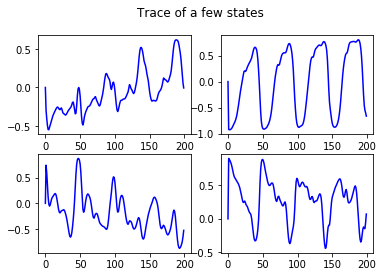

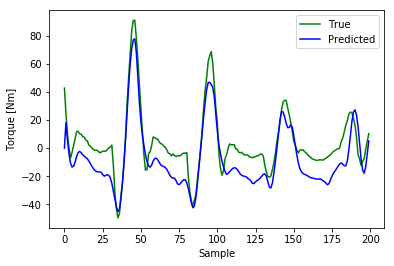

In [186]:
# Extract first torque vector
nOutputs = 1
yTrain = yTrain[:,0:1]
yTest = yTest[:,0:1]

# Parameters
nReservoir = 20
spectralRadius = 0.4

# Train and test
esn = ESN(nInputs, nReservoir, nOutputs,spectralRadius)
esn.train_single(uTrain,yTrain)
#esn.test(Train)
#esn.test(uTest)
